## Preparations


### Imports

In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=e163a5eb6d31f993b068d00385f181a9e4e1c461fbed568d138385072e812cc3
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


Cloning into 'multimodal_analysis'...
remote: Enumerating objects: 393, done.
remote: Counting objects: 100% (393/393), done.
remote: Compressing objects: 100% (302/302), done.
remote: Total 393 (delta 187), reused 150 (delta 52), pack-reused 0
Receiving objects: 100% (393/393), 2.95 MiB | 10.01 MiB/s, done.
Resolving deltas: 100% (187/187), done.


In [ ]:
#mv multimodal_analysis/demos/lxmert .

In [ ]:
#mv multimodal_analysis/src/mma/analysis/surrogates/lime/* .
#mv lime.py limee.py

In [ ]:
!pip install lime

     |████████████████████████████████| 275 kB 4.3 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=9e2f5a9ced66f1e082b5f6080e2929ea39c2cab84fb1df199a37712503b90371
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
import torch, torchvision
import matplotlib.pyplot as plt
import json
import cv2
import torch.nn.functional as F
import numpy as np
from copy import deepcopy

In [ ]:
#from mma.analysis.surrogates.lime.lime import Lime

In [ ]:
#torchvision.__version__

In [ ]:
#pip install torch==1.10.0

In [ ]:
pip install transformers

     |████████████████████████████████| 3.4 MB 4.2 MB/s 
     |████████████████████████████████| 895 kB 45.7 MB/s 
     |████████████████████████████████| 3.3 MB 48.1 MB/s 
     |████████████████████████████████| 61 kB 565 kB/s 
     |████████████████████████████████| 596 kB 49.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
#pip install torchvision==0.10.1+cu111

### Download the VQA v2 Validation Set

In [ ]:
# questions
%%capture
!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Val_mscoco.zip 
!unzip v2_Questions_Val_mscoco.zip

In [ ]:
# images
%%capture
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip val2014.zip

In [ ]:
# answers
%%capture
!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Val_mscoco.zip
!unzip v2_Annotations_Val_mscoco.zip

In [ ]:
with open('v2_OpenEnded_mscoco_val2014_questions.json') as f:
    q = json.load(f)

In [ ]:
with open('v2_mscoco_val2014_annotations.json') as f:
    a = json.load(f)

### Get model and related classes

In [ ]:
import os
os.makedirs('tmp')

In [ ]:
from transformers import LxmertForQuestionAnswering, LxmertTokenizer

In [ ]:
lxmert_tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")
lxmert_vqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-vqa-uncased").cuda()

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/153 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/776 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/880 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/816M [00:00<?, ?B/s]

In [ ]:

from lxmert import utils
from lxmert.utils import Config
from lxmert.processing_image import Preprocess
from lxmert.modeling_frcnn import GeneralizedRCNN

In [ ]:
OBJ_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/objects_vocab.txt"
ATTR_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/attributes_vocab.txt"
VQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/vqa/trainval_label2ans.json"

In [ ]:
# load object, attribute, and answer labels

objids = utils.get_data(OBJ_URL) # 1600 objects
attrids = utils.get_data(ATTR_URL) # 400 attributes
vqa_answers = utils.get_data(VQA_URL) # 3129 answers


In [ ]:
# load model components
frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")

frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg).cuda()

image_preprocess = Preprocess(frcnn_cfg)

%s not found in cache or force_download set to True, downloading to %s https://s3.amazonaws.com/models.huggingface.co/bert/unc-nlp/frcnn-vg-finetuned/config.yaml /root/.cache/torch/transformers/tmp75fkw86l


Downloading:   0%|          | 0.00/2.13k [00:00<?, ?B/s]

loading configuration file cache
%s not found in cache or force_download set to True, downloading to %s https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin /root/.cache/torch/transformers/tmptskbjhxg


Downloading:   0%|          | 0.00/262M [00:00<?, ?B/s]

loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /root/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


### Show Example point

In [ ]:
idx = 3401

In [ ]:
question_info = q["questions"][idx]
image_id = question_info['image_id']
ids=[]
for id in range(len(q["questions"])):
  question_info2 = q["questions"][id]
  image_id2 = question_info2['image_id']
  if image_id2==image_id:
    ids.append(id)
ids

[3393, 3394, 3395, 3396, 3397, 3398, 3399, 3400, 3401, 3402]

In [ ]:
question_info = q["questions"][idx]
image_id = question_info['image_id']
question1 = question_info['question']
question_id = question_info['question_id']

In [ ]:
answer_info = a['annotations'][idx]
answer_word1 = answer_info['multiple_choice_answer']
assert question_id == answer_info['question_id']

In [ ]:
img1 = plt.imread(f'val2014/COCO_val2014_{image_id:012d}.jpg')

# Detectron expects BGR images
img_bgr1 = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)

In [ ]:
print(img1.shape)

(428, 640, 3)


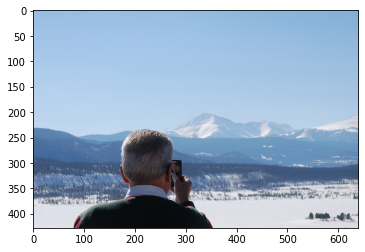

In [ ]:
plt.imshow(img1)
plt.show()

In [ ]:
question1

'Does this look like fun?'

In [ ]:
answer_word1

'yes'

In [ ]:
correctanswerindex=vqa_answers.index(answer_word1)

In [ ]:
text = question1

Running LXMERT prediction

In [ ]:
# run frcnn
images, sizes, scales_yx = image_preprocess(f'val2014/COCO_val2014_{image_id:012d}.jpg')

output_dict = frcnn(
    images.cuda(), 
    sizes.cuda(), 
    scales_yx=scales_yx.cuda(), 
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt",
    location="cuda"
)
# add boxes and labels to the image


test_questions_for_url2 = [
    question1
]

#Very important that the boxes are normalized
normalized_boxes = output_dict.get("normalized_boxes")
features = output_dict.get("roi_features")

for test_question in test_questions_for_url2:
    # run lxmert
    test_question = [test_question]

    inputs = lxmert_tokenizer(
        test_question,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )

    output_vqa = lxmert_vqa(
        input_ids=inputs.input_ids.cuda(),
        attention_mask=inputs.attention_mask.cuda(),
        visual_feats=features.cuda(),
        visual_pos=normalized_boxes.cuda(),
        token_type_ids=inputs.token_type_ids.cuda(),
        output_attentions=False,
    )
    # get prediction
    pred_vqa = output_vqa["question_answering_score"].argmax(-1)
    print(pred_vqa)

    print("Question:", test_question)
    print("prediction from LXMERT VQA:", vqa_answers[pred_vqa])

tensor([425], device='cuda:0')
Question: ['Does this look like fun?']
prediction from LXMERT VQA: yes


## LIME

In [ ]:
pred_vqa = pred_vqa.item()

In [ ]:
correctanswerindex

425

In [ ]:
text

'Does this look like fun?'

In [ ]:
import requests
import PIL

In [ ]:
image = np.asarray(PIL.Image.open(f'val2014/COCO_val2014_{image_id:012d}.jpg'))
image = cv2.resize(image, (224, 224))

Running LIME on text modality

In [ ]:
class_names = vqa_answers

def text_predictor_fn(texts):
    inputs = lxmert_tokenizer(
        texts,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )
    outputs = lxmert_vqa(
        input_ids=inputs.input_ids.cuda(),
        attention_mask=inputs.attention_mask.cuda(),
        visual_feats=features.cuda(),
        visual_pos=normalized_boxes.cuda(),
        token_type_ids=inputs.token_type_ids.cuda(),
        output_attentions=False,
    )
    probas = F.softmax(outputs['question_answering_score']).cpu().detach().numpy()
    return probas

In [ ]:
from limee import Lime

In [ ]:
init_params = {
    "class_names": class_names
}
explanation_params = {
    "labels": (correctanswerindex,pred_vqa),
    "num_samples":100
}
text_exp = Lime.explain_text_instance(text_predictor_fn, text, init_params, explanation_params)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
text_exp.local_exp

{425: [(4, 0.4937815478044543),
  (0, 0.07895994719281857),
  (1, 0.044667226929965),
  (3, -0.029692915727391737),
  (2, 0.02296428250711234)]}

LIME on text on correct label

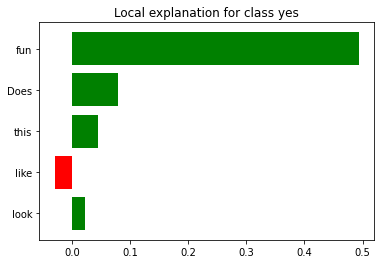

In [ ]:
text_fig = text_exp.as_pyplot_figure(label=correctanswerindex)

LIME on text on predicted label

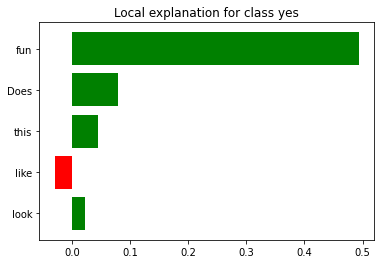

In [ ]:
text_fig = text_exp.as_pyplot_figure(label=pred_vqa)

Running LIME on image

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from skimage.segmentation import mark_boundaries

In [ ]:
inputs = lxmert_tokenizer(
        q["questions"][idx]["question"],
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )

In [ ]:
def image_predictor_fn(images):
    image_paths = []
    for i in range(len(images)):
        plt.imsave(f"./tmp/{i}.jpg", images[i])
        image_paths.append(f"./tmp/{i}.jpg")

    images, sizes, scales_yx = image_preprocess(image_paths)

    output_dict = frcnn(
        images.cuda(), 
        sizes.cuda(), 
        scales_yx=scales_yx.cuda(), 
        padding="max_detections",
        max_detections=frcnn_cfg.max_detections,
        return_tensors="pt",
        location="cuda"
    )
    #Very important that the boxes are normalized
    normalized_boxes = output_dict.get("normalized_boxes")
    features = output_dict.get("roi_features")
    with torch.no_grad():
        outputs = lxmert_vqa(
            input_ids=inputs.input_ids.cuda(),
            attention_mask=inputs.attention_mask.cuda(),
            visual_feats=features.cuda(),
            visual_pos=normalized_boxes.cuda(),
            token_type_ids=inputs.token_type_ids.cuda(),
            output_attentions=False,
        )
    
    probas = F.softmax(outputs['question_answering_score']).cpu().detach().numpy()
    return probas

In [ ]:
init_params = {}
explanation_params = {
    "labels": (correctanswerindex,pred_vqa),
    "hide_color": 0,
    "num_samples": 30,
    "batch_size": 5
}
image_exp = Lime.explain_image_instance(image_predictor_fn, np.array(image), init_params, explanation_params)

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


LIME on image on correct label

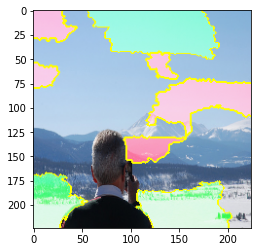

In [ ]:
temp, mask = image_exp.get_image_and_mask(correctanswerindex, positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

In [ ]:
#411 in image_exp.local_exp

LIME on image on predicted label

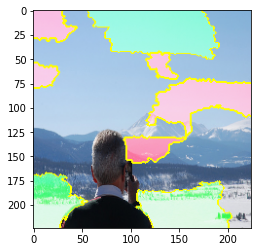

In [ ]:
temp, mask = image_exp.get_image_and_mask(pred_vqa, positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

# DIME preparation

In [ ]:
idxs=[i*100+1 for i in range(100)]
imags=[]
boxes=[]
featureses=[]
questions=[]
textinputs=[]
for id1 in idxs:
  questioninfo1 = q["questions"][id1]
  imageid1 = questioninfo1['image_id']
  imag1 = np.asarray(PIL.Image.open(f'val2014/COCO_val2014_{imageid1:012d}.jpg'))
  imag1 = cv2.resize(imag1, (224, 224))
  imags.append(imag1)
  images, sizes, scales_yx = image_preprocess([f'val2014/COCO_val2014_{imageid1:012d}.jpg'])
  output_dict = frcnn(
        images.cuda(), 
        sizes.cuda(), 
        scales_yx=scales_yx.cuda(), 
        padding="max_detections",
        max_detections=frcnn_cfg.max_detections,
        return_tensors="pt",
        location="cuda"
  )
  normalized_boxes = output_dict.get("normalized_boxes")
  features = output_dict.get("roi_features")
  boxes.append(normalized_boxes)
  featureses.append(features)

  questioninfo2 = q["questions"][id1]
  question2 = questioninfo2['question']
  questionid2 = questioninfo2['question_id']
  answerinfo2 = a['annotations'][id1]
  answerword2 = answerinfo2['multiple_choice_answer']
  assert questionid2 == answerinfo2['question_id']
  questions.append(question2)

  inputs = lxmert_tokenizer(
        [question2],
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )
  textinputs.append(inputs)







In [ ]:
storage = torch.zeros(100,100,3129).cuda()

with torch.no_grad():
  for id1 in idxs:
    for id2 in idxs:
      print("At "+str(id1)+" "+str(id2))
      outputs = lxmert_vqa(
          input_ids=textinputs[id2//100].input_ids.cuda(),
          attention_mask=textinputs[id2//100].attention_mask.cuda(),
          visual_feats=featureses[id1//100].cuda(),
          visual_pos=boxes[id1//100].cuda(),
          token_type_ids=textinputs[id2//100].token_type_ids.cuda(),
          output_attentions=False,
      )
      storage[id1//100][id2//100]=outputs['question_answering_score'][0]


Streaming output truncated to the last 5000 lines.
At 5001 1
At 5001 101
At 5001 201
At 5001 301
At 5001 401
At 5001 501
At 5001 601
At 5001 701
At 5001 801
At 5001 901
At 5001 1001
At 5001 1101
At 5001 1201
At 5001 1301
At 5001 1401
At 5001 1501
At 5001 1601
At 5001 1701
At 5001 1801
At 5001 1901
At 5001 2001
At 5001 2101
At 5001 2201
At 5001 2301
At 5001 2401
At 5001 2501
At 5001 2601
At 5001 2701
At 5001 2801
At 5001 2901
At 5001 3001
At 5001 3101
At 5001 3201
At 5001 3301
At 5001 3401
At 5001 3501
At 5001 3601
At 5001 3701
At 5001 3801
At 5001 3901
At 5001 4001
At 5001 4101
At 5001 4201
At 5001 4301
At 5001 4401
At 5001 4501
At 5001 4601
At 5001 4701
At 5001 4801
At 5001 4901
At 5001 5001
At 5001 5101
At 5001 5201
At 5001 5301
At 5001 5401
At 5001 5501
At 5001 5601
At 5001 5701
At 5001 5801
At 5001 5901
At 5001 6001
At 5001 6101
At 5001 6201
At 5001 6301
At 5001 6401
At 5001 6501
At 5001 6601
At 5001 6701
At 5001 6801
At 5001 6901
At 5001 7001
At 5001 7101
At 5001 7201
At 5001 7301

# Running DIME on selected point

In [ ]:
avg0=torch.mean(storage,dim=1)
avg1=torch.mean(storage,dim=0)
avg=torch.mean(avg0)
emap = avg0[idx//100]+avg1[idx//100]-avg
inter = storage[idx//100][idx//100] - emap
print(emap[correctanswerindex])
print(inter[correctanswerindex])
print(emap[pred_vqa])
print(inter[pred_vqa])

tensor(20.1429, device='cuda:0')
tensor(-5.1206, device='cuda:0')
tensor(20.1429, device='cuda:0')
tensor(-5.1206, device='cuda:0')


In [ ]:

import copy
def imgemape(inps):
  image_paths = []
  rets = []
  for ii in range(len(inps)):
    plt.imsave(f"./tmp/{ii}.jpg", inps[ii])
    image_paths.append(f"./tmp/{ii}.jpg")
    images, sizes, scales_yx = image_preprocess(image_paths[ii:ii+1])
    output_dict = frcnn(
        images.cuda(), 
        sizes.cuda(), 
        scales_yx=scales_yx.cuda(), 
        padding="max_detections",
        max_detections=frcnn_cfg.max_detections,
        return_tensors="pt",
        location="cuda"
    )
    #Very important that the boxes are normalized
    normalized_boxes = output_dict.get("normalized_boxes")
    features = output_dict.get("roi_features")
    with torch.no_grad():
      origs1=storage[:,:,correctanswerindex]
      newstorage1 = copy.deepcopy(origs1)
      origs2=storage[:,:,pred_vqa]
      newstorage2 = copy.deepcopy(origs2)
      for j in range(100):
        outputs = lxmert_vqa(
          input_ids=textinputs[j].input_ids.cuda(),
          attention_mask=textinputs[j].attention_mask.cuda(),
          visual_feats=features.cuda(),
          visual_pos=normalized_boxes.cuda(),
          token_type_ids=textinputs[j].token_type_ids.cuda(),
          output_attentions=False,
        )
        newstorage1[idx//100][j]=outputs['question_answering_score'][0][correctanswerindex]
        newstorage2[idx//100][j]=outputs['question_answering_score'][0][pred_vqa]
      avg0=torch.mean(newstorage1, dim=1)
      avg1=torch.mean(newstorage1, dim=0)
      avg = torch.mean(avg0)
      uniout1 = (avg0[idx//100]+avg1[idx//100]-avg).item()
      multiout1 = (newstorage1[idx//100][idx//100]-uniout1).item()
      avg0=torch.mean(newstorage2, dim=1)
      avg1=torch.mean(newstorage2, dim=0)
      avg = torch.mean(avg0)
      uniout2 = (avg0[idx//100]+avg1[idx//100]-avg).item()
      multiout2 = (newstorage2[idx//100][idx//100]-uniout2).item()
      #print(newstorage[idx//100][idx//100].item())
      #print(uniout)
      #print(multiout)
      rets.append([uniout1,multiout1,uniout2,multiout2])
  os.system("rm ./tmp/*.jpg")
  return np.array(rets)
    

  
init_params = {}
explanation_params = {
    "labels": (0,1,2,3),
    "hide_color": 0,
    "num_samples": 100,
    "batch_size": 5
}
image_exp = Lime.explain_image_instance(imgemape, np.array(image), init_params, explanation_params)


  0%|          | 0/100 [00:00<?, ?it/s]

The following is unimodal contribution image interpretation on correct label

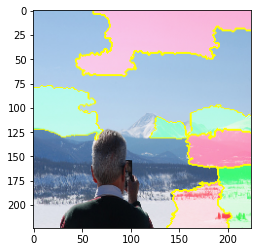

In [ ]:
temp, mask = image_exp.get_image_and_mask(0, positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

The following is multimodal interactive image interpretation on correct label

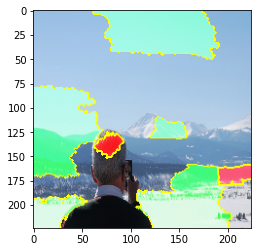

In [ ]:
temp, mask = image_exp.get_image_and_mask(1, positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

The following is unimodal contribution image interpretation on predicted label

---



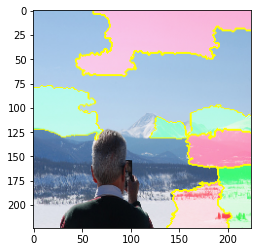

In [ ]:
temp, mask = image_exp.get_image_and_mask(2, positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

The following is multimodal interaction image interpretation on predicted label

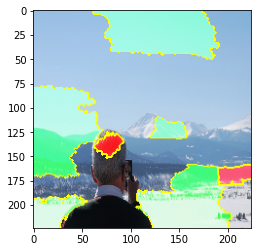

In [ ]:
temp, mask = image_exp.get_image_and_mask(3, positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

In [ ]:
def txtemape(inps):
  rets=[]
  for ii in range(len(inps)):
    inputs = lxmert_tokenizer(
        inps[ii:ii+1],
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )
    with torch.no_grad():
      origs1=storage[:,:,correctanswerindex]
      newstorage1 = copy.deepcopy(origs1)
      origs2=storage[:,:,pred_vqa]
      newstorage2 = copy.deepcopy(origs2)
      for j in range(100):
        outputs = lxmert_vqa(
          input_ids=inputs.input_ids.cuda(),
          attention_mask=inputs.attention_mask.cuda(),
          visual_feats=featureses[j].cuda(),
          visual_pos=boxes[j].cuda(),
          token_type_ids=inputs.token_type_ids.cuda(),
          output_attentions=False,
        )
        newstorage1[j][idx//100]=outputs['question_answering_score'][0][correctanswerindex]
        newstorage2[j][idx//100]=outputs['question_answering_score'][0][pred_vqa]
      avg0=torch.mean(newstorage1, dim=1)
      avg1=torch.mean(newstorage1, dim=0)
      avg = torch.mean(avg0)
      uniout1 = (avg0[idx//100]+avg1[idx//100]-avg).item()
      multiout1 = (newstorage1[idx//100][idx//100]-uniout1).item()
      avg0=torch.mean(newstorage2, dim=1)
      avg1=torch.mean(newstorage2, dim=0)
      avg = torch.mean(avg0)
      uniout2 = (avg0[idx//100]+avg1[idx//100]-avg).item()
      multiout2 = (newstorage2[idx//100][idx//100]-uniout2).item()
      rets.append([uniout1,multiout1,uniout2,multiout2])
  os.system("rm ./tmp/*.jpg")
  return np.array(rets)


init_params = {
}
explanation_params = {
    "labels": (0,1,2,3),
    "num_samples":100
}
text_exp = Lime.explain_text_instance(txtemape, text, init_params, explanation_params)

The following is unimodal contribution text interpretation on correct label

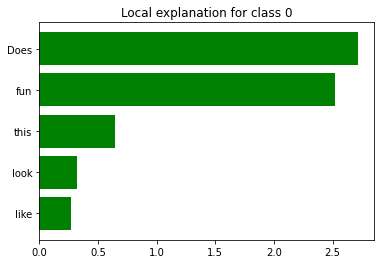

In [ ]:
text_fig = text_exp.as_pyplot_figure(label=0)

The following is multimodal interaction text interpretation on correct label

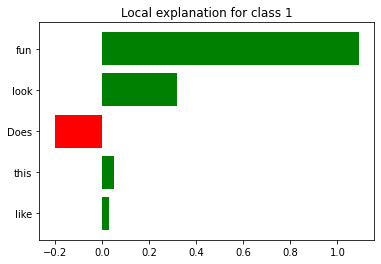

In [ ]:
text_fig = text_exp.as_pyplot_figure(label=1)

The following is unimodal contribution text interpretation on predicted label

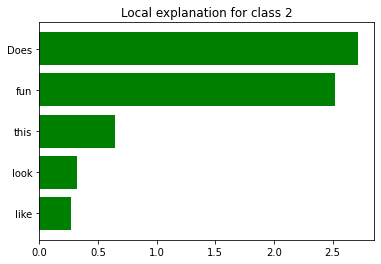

In [ ]:
text_fig = text_exp.as_pyplot_figure(label=2)

The following is multimodal interaction text interpretation on predicted label

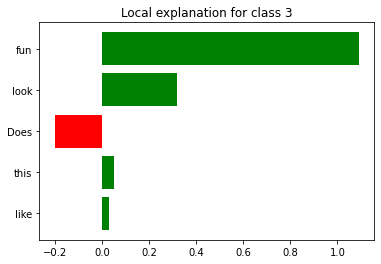

In [ ]:
text_fig = text_exp.as_pyplot_figure(label=3)